In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
from nltk.tokenize import regexp_tokenize
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from collections import defaultdict
import re, nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [5]:
# df = pd.read_csv("data/Tweets.csv")
# df.head()

In [6]:
#UMICH SI650 - Sentiment Classification
#https://www.kaggle.com/competitions/si650winter11/data

In [7]:
#Read test and train datasets
# header=0 -> first line contains column names
# delimiter=\t -> fields are separated by tabs
# quoting=3 -> ignore double quotes

train_data_df  = pd.read_table('data/si650winter11/training.txt', names=['sentiment', 'comment'], header=None, delimiter="\t", quoting=3)
test_data_df  = pd.read_table('data/si650winter11/testdata.txt', names=['comment'], header=None, delimiter="\t", quoting=3)

In [8]:
train_data_df.head(10)

,sentiment,comment
0,1,The Da Vinci Code book is just awesome.
1,1,this was the first clive cussler i've ever rea...
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly did...
5,1,that's not even an exaggeration ) and at midni...
6,1,"I loved the Da Vinci Code, but now I want some..."
7,1,"i thought da vinci code was great, same with k..."
8,1,The Da Vinci Code is actually a good movie...
9,1,I thought the Da Vinci Code was a pretty good ...


In [9]:
test_data_df.head(5)

,comment
0,""" I don't care what anyone says, I like Hillar..."
1,have an awesome time at purdue!..
2,"Yep, I'm still in London, which is pretty awes..."
3,"Have to say, I hate Paris Hilton's behavior bu..."
4,i will love the lakers.


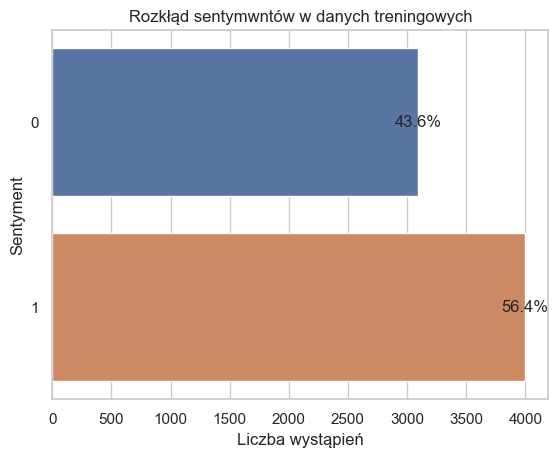

In [113]:
ax = sns.countplot(y="sentiment", data=train_data_df)
ax.set(title="Rozkłąd sentymwntów w danych treningowych", xlabel="Liczba wystąpień", ylabel="Sentyment")
total_freq = len(train_data_df)
for p in ax.patches:
    percentage = f'{100 * p.get_width() / total_freq:.1f}%'
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.show()

In [22]:
#number words per sentence
np.mean([len(s.split(" ")) for s in train_data_df.comment])

10.886819079875812

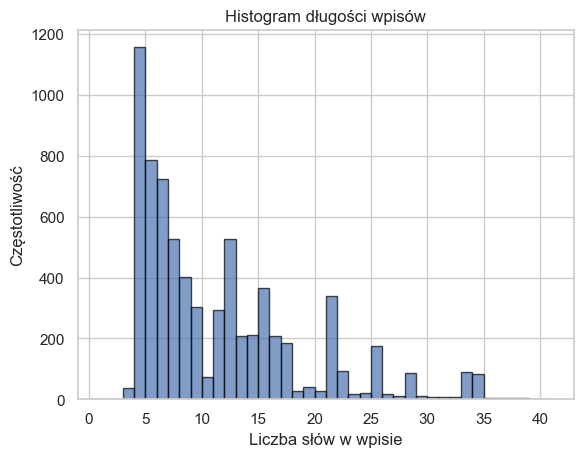

In [89]:
#Make a frequency list of lengths of tokenized each sentences
list_freq = [len(regexp_tokenize(s, "\w+")) for s in train_data_df["comment"]]

# Plot a histogram of the line lengths
#plt.figure(figsize=(8, 6))  # Ustawienie rozmiaru figury
plt.hist(list_freq, bins=range(1, max(list_freq) + 2), edgecolor='black', alpha=0.7)
plt.title("Histogram długości wpisów")
plt.xlabel("Liczba słów w wpisie")
plt.ylabel("Częstotliwość")
plt.show()

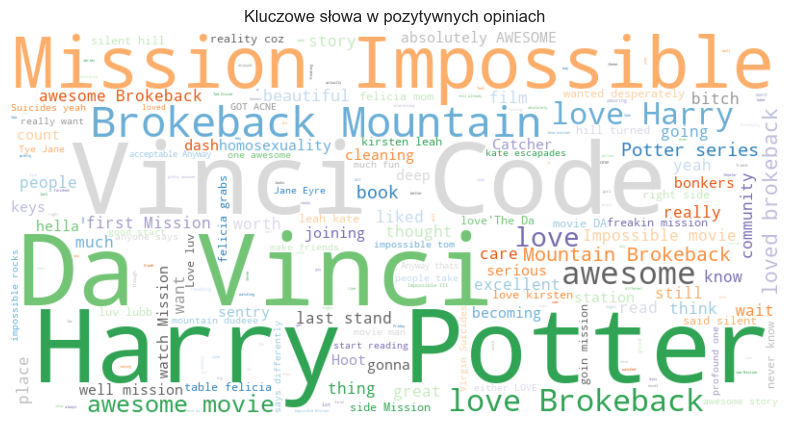

In [118]:
positive_comments = train_data_df[train_data_df['sentiment']==1]['comment']
text = " ".join(review for review in positive_comments)

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='tab20c').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Kluczowe słowa w pozytywnych opiniach")
plt.axis('off')
plt.show()

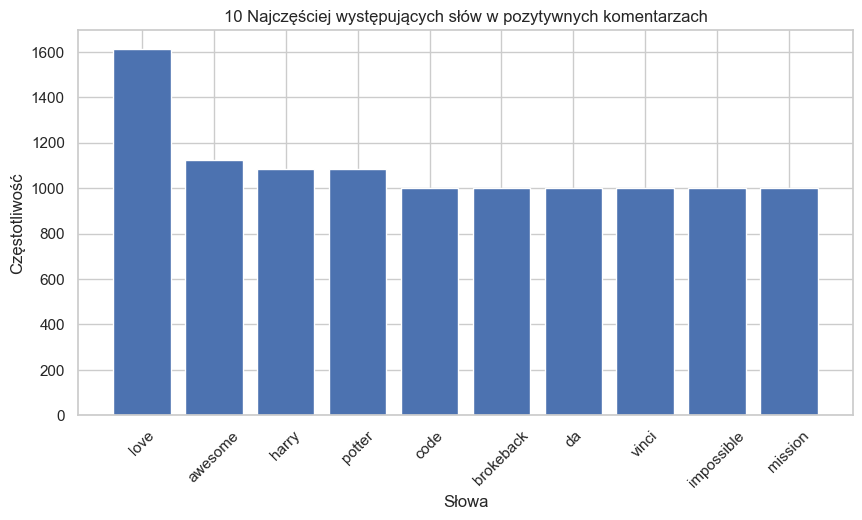

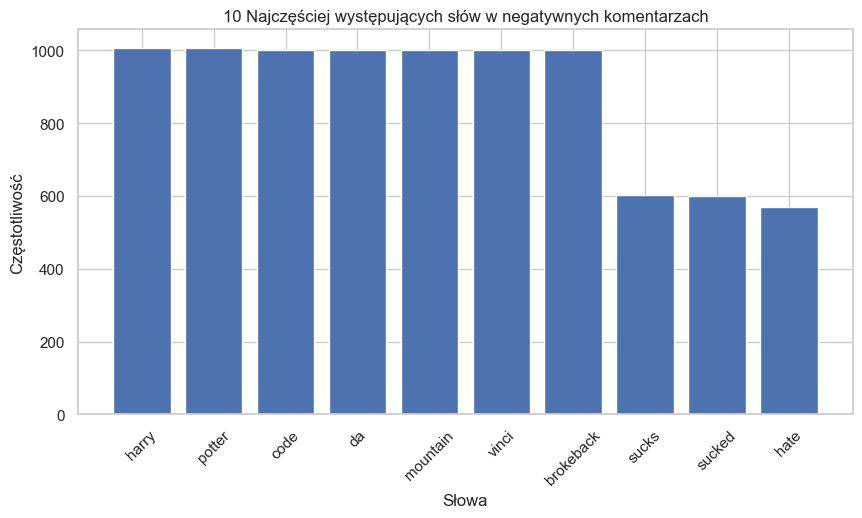

In [126]:
vectorizer = CountVectorizer(stop_words='english')

positive_comments = train_data_df[train_data_df['sentiment'] == 1]['comment']
positive_matrix = vectorizer.fit_transform(positive_comments)
positive_freq = zip(vectorizer.get_feature_names_out(), positive_matrix.sum(axis=0).tolist()[0])
positive_freq = sorted(positive_freq, key=lambda x: -x[1])

negative_comments = train_data_df[train_data_df['sentiment'] == 0]['comment']
negative_matrix = vectorizer.fit_transform(negative_comments)
negative_freq = zip(vectorizer.get_feature_names_out(), negative_matrix.sum(axis=0).tolist()[0])
negative_freq = sorted(negative_freq, key=lambda x: -x[1])

#Create histogram for top frequent words in positive comments
labels_pos, values_pos = zip(*positive_freq[:10])  
plt.figure(figsize=(10,5))
plt.bar(labels_pos, values_pos)
plt.title('10 Najczęściej występujących słów w pozytywnych komentarzach')
plt.ylabel('Częstotliwość')
plt.xlabel('Słowa')
plt.xticks(rotation=45)
plt.show()
#Create histogram for top frequent words in negative comments
labels_neg, values_neg = zip(*negative_freq[:10]) 
plt.figure(figsize=(10,5))
plt.bar(labels_neg, values_neg)
plt.title('10 Najczęściej występujących słów w negatywnych komentarzach')
plt.ylabel('Częstotliwość')
plt.xlabel('Słowa')
plt.xticks(rotation=45)
plt.show()

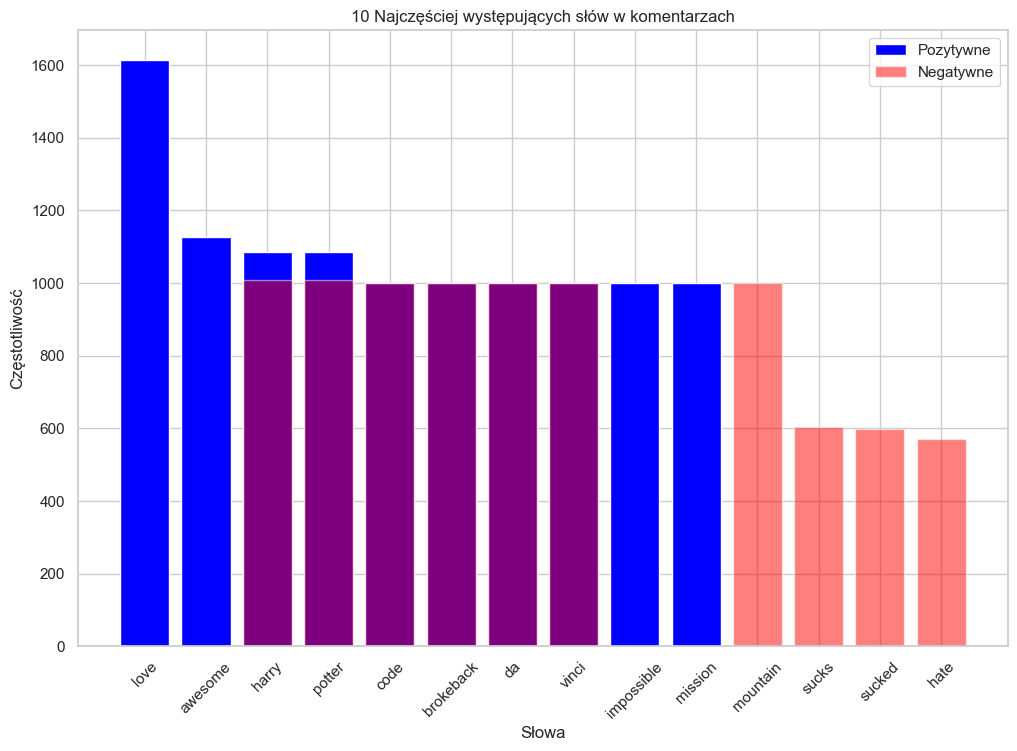

In [127]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(labels_pos, values_pos, color='blue', label='Pozytywne')
ax.bar(labels_neg, values_neg, color='red', label='Negatywne', alpha=0.5)
ax.set_title('10 Najczęściej występujących słów w komentarzach')
ax.set_ylabel('Częstotliwość')
ax.set_xlabel('Słowa')
ax.legend()
plt.xticks(rotation=45)
plt.show()

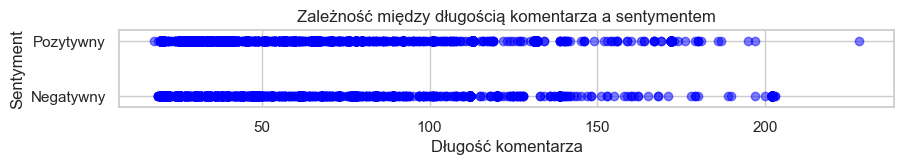

In [138]:
plt.figure(figsize=(10, 1))
plt.scatter(train_data_df['comment'].apply(len), train_data_df['sentiment'], color='blue', alpha=0.5)  # Ustawienie przezroczystości dla lepszej widoczności przy nakładaniu się punktów
plt.title('Zależność między długością komentarza a sentymentem')
plt.xlabel('Długość komentarza')
plt.ylabel('Sentyment')
plt.yticks([0, 1], ["Negatywny", "Pozytywny"])
plt.ylim(-0.2, 1.2) 
plt.grid(True)
plt.show()

In [157]:
defaultdict(list)

defaultdict(list, {})

In [175]:
#Dictionary to store sentiment lists for every word
sentiment_dict = defaultdict(list)

rows = []
for _, row in train_data_df.iterrows():
    words = row['comment'].lower().split() 
    for word in words:
        sentiment_dict[word].append(row['sentiment'])

def determine_color(sentiments):
    if all(s == 1 for s in sentiments):
        return 'green'
    elif all(s == 0 for s in sentiments):
        return 'red'
    else:
        return 'orange'

color_dict = {word: determine_color(sentiments) for word, sentiments in sentiment_dict.items()}

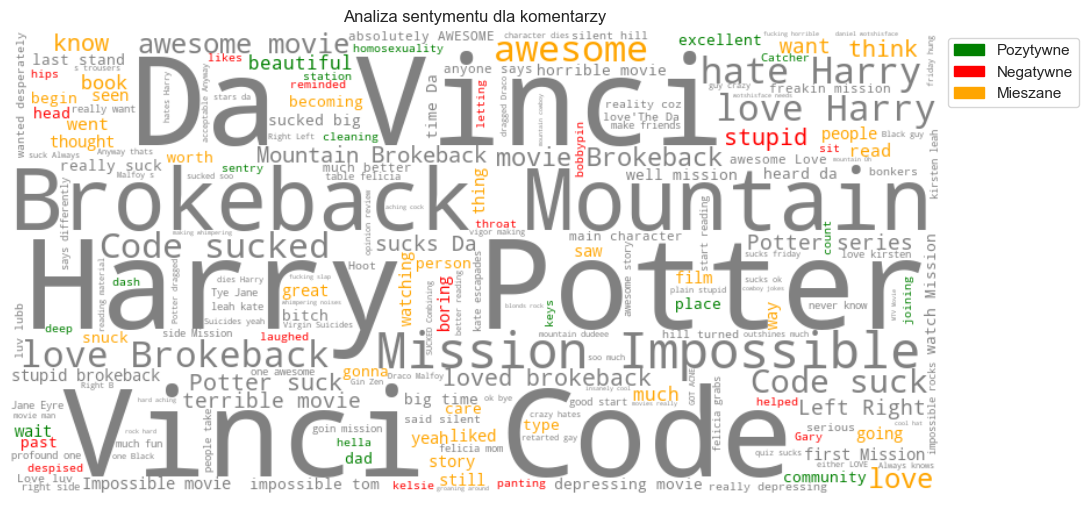

In [177]:
import matplotlib.patches as mpatches
#Function color_func use color dictionary
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return color_dict.get(word.lower(), 'grey')

text = ' '.join(train_data_df['comment'])

wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(text)
legend_elements = [
    mpatches.Patch(color='green', label='Pozytywne'),
    mpatches.Patch(color='red', label='Negatywne'),
    mpatches.Patch(color='orange', label='Mieszane')
]
plt.figure(figsize=(12, 7))
#plt.subplot(121)  # Użyj subplot, aby zrobić miejsce na legendę
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Analiza sentymentu dla komentarzy')
plt.axis('off')
plt.show()


In [23]:
#Preprocessing

In [179]:
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

In [180]:
def tokenize(text):
    text = re.sub("[^a-zA-Z]", " ", text) #remove non letters
    tokens = nltk.word_tokenize(text) #tokenize
    stems = stem_tokens(tokens, PorterStemmer()) #stem
    return stems

In [187]:
count_vect = CountVectorizer(analyzer='word', tokenizer=tokenize, lowercase=True, stop_words='english', max_features=100)
#fits the model, model learns the vocabulary and transforms corpus data into feature vectors
comment_tf = count_vect.fit_transform(train_data_df.comment.tolist() + test_data_df.comment.tolist())
#to numpy
comment_tf_nd = comment_tf.toarray()
comment_tf_nd.shape

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warni

(40138, 100)

In [193]:
print("Comments term frequency (CountVectorize): ")
pd.DataFrame(comment_tf_nd, columns=count_vect.get_feature_names_out()).head(5)

Term frequency (CountVectorize): 


,aaa,airlin,amaz,angelina,awesom,beauti,becaus,big,boston,brokeback,...,toyota,ucla,ve,vinci,wa,want,way,whi,work,world
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [209]:
tfidf_vect = TfidfVectorizer(analyzer='word', tokenizer=tokenize, lowercase=True, stop_words='english', max_features=100, smooth_idf=False)
comment_tfidf = tfidf_vect.fit_transform(train_data_df.comment.tolist() + test_data_df.comment.tolist())
comment_tfidf_nd = comment_tfidf.toarray()
comment_tfidf_nd.shape

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warni

(40138, 100)

In [210]:
print("Comments term frequency-inverse document frequency (tf-idf):")
pd.DataFrame(comment_tfidf_nd, columns=tfidf_vect.get_feature_names_out()).head(5)

Comments term frequency-inverse document frequency (tf-idf):


,aaa,airlin,amaz,angelina,awesom,beauti,becaus,big,boston,brokeback,...,toyota,ucla,ve,vinci,wa,want,way,whi,work,world
0,0.0,0.0,0.0,0.0,0.391895,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.442319,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.384584,0.310759,0.272596,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.420995,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.420995,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.421334,0.000000,0.0,0.0,0.0,0.0,0.0


In [211]:
#words in vocabulary
vocab = count_vect.get_feature_names_out()
print(vocab)

['aaa' 'airlin' 'amaz' 'angelina' 'awesom' 'beauti' 'becaus' 'big'
 'boston' 'brokeback' 'car' 'citi' 'clinton' 'code' 'cool' 'crappi'
 'cruis' 'd' 'da' 'doe' 'don' 'drive' 'francisco' 'friend' 'fuck' 'fun'
 'geico' 'god' 'good' 'got' 'great' 'guy' 'ha' 'harri' 'harvard' 'hate'
 'hi' 'hilton' 'honda' 'imposs' 'joli' 'just' 'know' 'laker' 'left' 'like'
 'littl' 'london' 'look' 'lot' 'love' 'm' 'macbook' 'make' 'miss'
 'mission' 'mit' 'mountain' 'movi' 'na' 'need' 'new' 'oh' 'onli' 'pari'
 'peopl' 'person' 'potter' 'pretti' 'purdu' 'realli' 'right' 'rock' 's'
 'said' 'san' 'say' 'school' 'seattl' 'shanghai' 'shitti' 'stori' 'stupid'
 'suck' 't' 'thi' 'thing' 'think' 'time' 'tom' 'toyota' 'ucla' 've'
 'vinci' 'wa' 'want' 'way' 'whi' 'work' 'world']


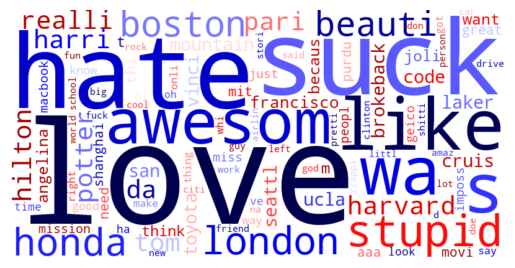

In [212]:
sum_vocab = np.sum(comment_tf_nd, axis=0)
word_frequencies = dict(zip(vocab, sum_vocab))
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap='seismic',).generate_from_frequencies(word_frequencies)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [239]:
# find some good and bad words
selected_words = ['awesom', 'good', 'great', 'like', 'shitti', 'stupid', 'suck']
sum_data = dict()
for word in selected_words:
    sum_data[word] = df[word].sum()
sum_data
df_subset = df[selected_words]
X_train, X_test, y_train, y_test  = train_test_split(df_subset[0:len(train_data_df)], train_data_df.sentiment, 
                                                     train_size=0.75, random_state=1, 
                                                     stratify=train_data_df.sentiment)

# Create and train the Logistic Regression Classifier
log_sw_model = LogisticRegression()
log_sw_model = log_tfidf_model.fit(X=X_train, y=y_train)

y_pred = log_sw_model.predict(X=X_test)
y_pred_prob = log_sw_model.predict_proba(X=X_test)[:,1]
fpr_sw, tpr_sw, thresholds = metrics.roc_curve(y_test, y_pred_prob)
roc_auc_sw = metrics.auc(fpr_sw, tpr_sw)

In [234]:
#tf-idf linear classifier
# train and validation set split
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(comment_tfidf_nd[0:len(train_data_df)], 
                                                                             train_data_df.sentiment, 
                                                                             train_size=0.75, 
                                                                             random_state=1, 
                                                                             stratify=train_data_df.sentiment)

log_tfidf_model = LogisticRegression()
log_tfidf_model = log_tfidf_model.fit(X=X_train_tfidf, y=y_train_tfidf)
# classifier to label an evaluation set
y_pred_tfidf = log_tfidf_model.predict(X=X_test_tfidf)
y_pred_prob_tfidf = log_tfidf_model.predict_proba(X=X_test_tfidf)[:,1]

print(metrics.classification_report(y_test_tfidf, y_pred_tfidf))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       773
           1       0.98      0.99      0.99       999

    accuracy                           0.98      1772
   macro avg       0.98      0.98      0.98      1772
weighted avg       0.98      0.98      0.98      1772



In [235]:
fpr_tfidf, tpr_tfidf, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf)
roc_auc_tfidf = metrics.auc(fpr_tfidf, tpr_tfidf)
roc_auc_tfidf

0.9984350456536742

In [228]:
#tf-idf linear classifier
# train and validation set split
X_train_tf, X_test_tf, y_train_tf, y_test_tf  = train_test_split(comment_tf_nd[0:len(train_data_df)], 
                                                                 train_data_df.sentiment, 
                                                                 train_size=0.75, 
                                                                 random_state=1, 
                                                                 stratify=train_data_df.sentiment)

log_tf_model = LogisticRegression()
log_tf_model = log_tf_model.fit(X=X_train_tf, y=y_train_tf)
# classifier to label an evaluation set
y_pred_tf = log_tf_model.predict(X=X_test_tf)
y_pred_prob_tf = log_tf_model.predict_proba(X=X_test_tf)[:,1]

print(metrics.classification_report(y_test_tf, y_pred_tf))
fpr_tf, tpr_tf, thresholds = metrics.roc_curve(y_test_tf, y_pred_prob_tf)
roc_auc_tf = metrics.auc(fpr_tf, tpr_tf)
roc_auc_tf

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       773
           1       0.99      0.99      0.99       999

    accuracy                           0.99      1772
   macro avg       0.99      0.99      0.99      1772
weighted avg       0.99      0.99      0.99      1772



0.9978814519564843

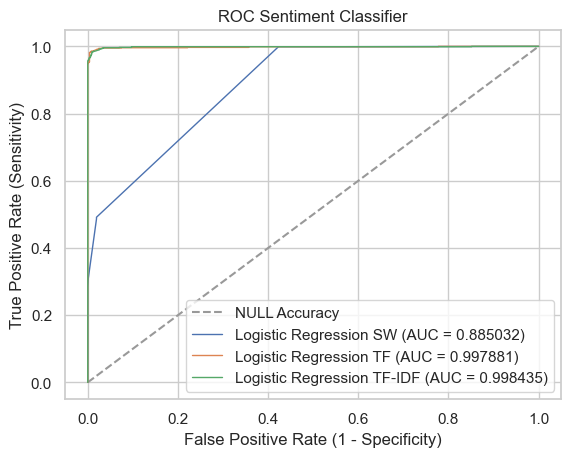

In [240]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_sw, tpr_sw, lw=1, label='Logistic Regression SW (AUC = %0.6f)' % roc_auc_sw)
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [242]:
comment_tfidf_nd[0:len(train_data_df)]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
tfidf_vect = TfidfVectorizer(analyzer='word', tokenizer=tokenize, lowercase=True, stop_words='english', max_features=100, smooth_idf=True)
comment_tfidf = tfidf_vect.fit_transform(train_data_df.comment.tolist() + test_data_df.comment.tolist())
comment_tfidf_nd = comment_tfidf.toarray()
comment_tfidf_nd.shape
#tf-idf linear classifier
# train and validation set split
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf  = train_test_split(comment_tfidf_nd[0:len(train_data_df)], train_data_df.sentiment, train_size=0.75, random_state=1, stratify=train_data_df.sentiment)

# Logistic Regression Classifier
log_tfidf_model = LogisticRegression()
log_tfidf_model = log_tfidf_model.fit(X=X_train_tfidf, y=y_train_tfidf)
# classifier to label an evaluation set
y_pred_tfidf = log_tfidf_model.predict(X=X_test_tfidf)
y_pred_prob_tfidf = log_tfidf_model.predict_proba(X=X_test_tfidf)[:,1]
fpr_tfidf_smooth, tpr_tfidf_smooth, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf)
roc_auc_tfidf_smooth = metrics.auc(fpr_tfidf_smooth, tpr_tfidf_smooth)

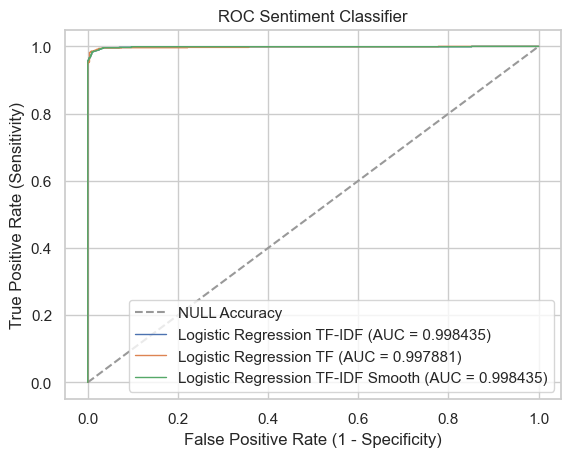

In [222]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tfidf_smooth, tpr_tfidf_smooth, lw=1, label='Logistic Regression TF-IDF Smooth (AUC = %0.6f)' % roc_auc_tfidf_smooth)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [69]:
#predicted unlabelled data
# get predictions
test_pred = log_tfidf_model.predict(comment_tfidf_nd[len(train_data_df):])
# let's sample some of them
import random
spl = random.sample(range(len(test_pred)), 15)

for text, sentiment in zip(test_data_df.comment[spl], test_pred[spl]):
    print(sentiment, text)

0 Though I want a Vios / Honda Jazz badly, I think I'll be fine in a 2nd hand Myvi or Waja or Gen 2 or anything decent.
0 just because HARVARD SUCKS!....
1 That's why I most love the Harvard story:
1 PURDUE FUCKIN ROCKS!!!
0 I basically hate Tom Cruise and I thought the film was overrated.
0 i hate 3 paris hilton, halary duff, lindsay lohan.
0 I've prayed and been praying that God bless the UCLA Taekwondo program and let me do His work through it.
0 and i blame angelina jolie!
1 Dell Inspiron 630 rocks!!!!
0 LAKERS SUCKS.
1 I officially love AAA even if they cant find my car and I have to run all over the dorm area trying to find the AAA person <. < yeah...
1 I'm loving Shanghai > > > ^ _ ^.
0 i hate myspace with a fiery passion, and i hate paris hilton as well.
0 I miss Boston so much it hurts sometimes, but I know that I'm really just missing this time of my life and the people from it...
1 As the lightening strook and the thunder rolled in the late evening, I drove me and my two bud

In [16]:
#vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [26]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

In [17]:
def sentiment_score(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    if sentence != sentence:
        return None
    sentence_dict = sid_obj.polarity_scores(sentence)
    if sentence_dict["compound"] >= 0.5:
        return 1
    else:
        return 0

In [29]:
train_data_df["sentiment_pred_vader"] = train_data_df.apply(lambda sentence: sentiment_score(sentence["comment"]), axis=1)

In [34]:
from sklearn import metrics
print(metrics.classification_report(train_data_df["sentiment"], train_data_df["sentiment_pred_vader"]))

              precision    recall  f1-score   support

           0       0.78      0.94      0.86      3091
           1       0.95      0.80      0.87      3995

    accuracy                           0.86      7086
   macro avg       0.86      0.87      0.86      7086
weighted avg       0.88      0.86      0.86      7086



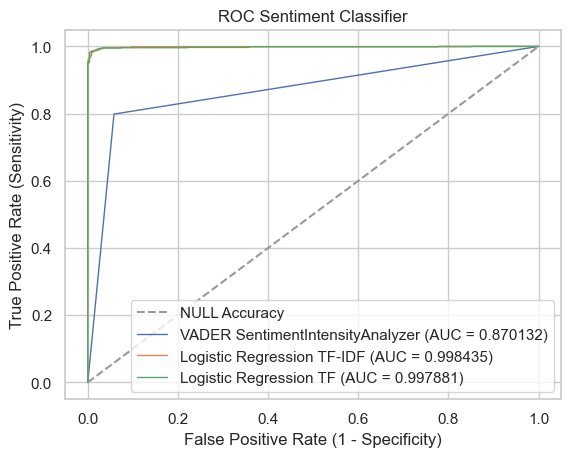

In [58]:
fpr_vader, tpr_vader, thresholds = metrics.roc_curve(train_data_df["sentiment"], train_data_df["sentiment_pred_vader"])
roc_auc_vader = metrics.auc(fpr_vader, tpr_vader)
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [67]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocessed_text(sentence):
    if sentence != sentence:
        return None
    tokens = word_tokenize(sentence.lower())
    filtered_tokens = [token for token in tokens if token not in stopwords.words("english")]
    #lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    processed_text = " ".join(lemmatized_tokens)
    return processed_text

In [68]:
train_data_df["processed_text"] = train_data_df["comment"].apply(preprocessed_text)
#difference between original and with lemmatization
train_data_df["sentiment_pred_lem"] = train_data_df.apply(lambda sentence: sentiment_score(sentence["processed_text"]), axis=1)

In [70]:
fpr_lemmatizer, tpr_lemmatizer, thresholds = metrics.roc_curve(train_data_df["sentiment"], train_data_df["sentiment_pred_lem"])
roc_auc_lemmatizer = metrics.auc(fpr_lemmatizer, tpr_lemmatizer)

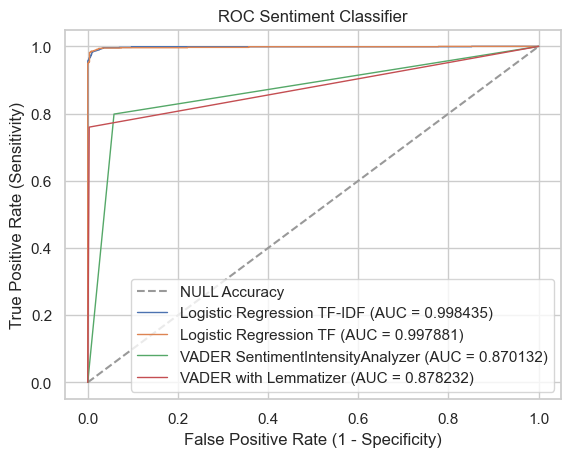

In [71]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [74]:
from nltk.stem import WordNetLemmatizer
import re
# Initialize wordnet lemmatizer
wnl = WordNetLemmatizer()
#perform lemmatizer
def text_to_lemmatize_string(text):
    if text != text:
        return None
    else:
        #change sentences to list to perform lemmatizer
        sentence_endings = r"[?! ]"
        string_list = re.split(sentence_endings, text)
        lemmatize_string = ""
        for string in string_list:
            lemmatize_string += (wnl.lemmatize(string, pos = "v") + " ")
        return lemmatize_string

train_data_df["list_lem"] = train_data_df.apply(lambda row: text_to_lemmatize_string(row["comment"]), axis=1)

In [75]:
#difference between original and with lemmatization
train_data_df["sentiment_pred_wnl"] = train_data_df.apply(lambda sentence: sentiment_score(sentence["list_lem"]), axis=1)
fpr_list_lem, tpr_list_lem, thresholds = metrics.roc_curve(train_data_df["sentiment"], train_data_df["sentiment_pred_wnl"])
roc_auc_list_lem = metrics.auc(fpr_list_lem, tpr_list_lem)

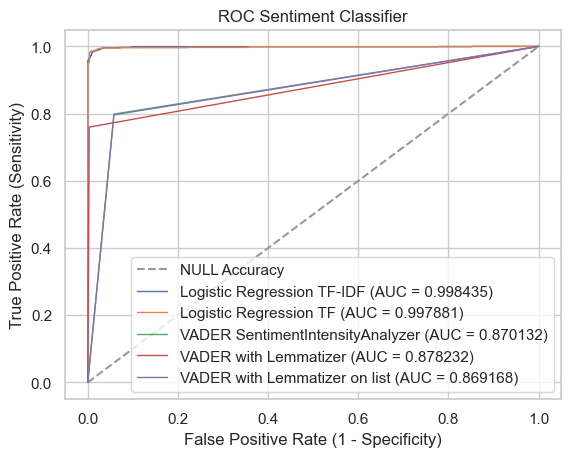

In [76]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_list_lem, tpr_list_lem, lw=1, label='VADER with Lemmatizer on list (AUC = %0.6f)' % roc_auc_list_lem)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [245]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_tfidf, y_train_tfidf)

# classifier to label an evaluation set
y_pred_tfid_knn = knn_model.predict(X=X_test_tfidf)
y_pred_prob_tfidf_knn = knn_model.predict_proba(X=X_test_tfidf)[:,1]
fpr_tfidf_knn, tpr_tfidf_knn, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf_knn)
roc_auc_tfidf_knn = metrics.auc(fpr_tfidf_knn, tpr_tfidf_knn)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


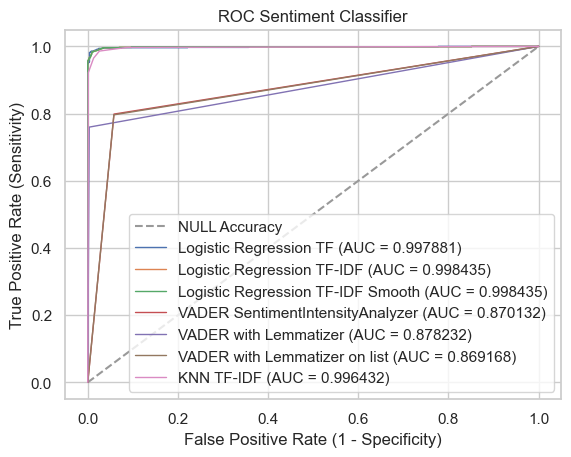

In [248]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tfidf_smooth, tpr_tfidf_smooth, lw=1, label='Logistic Regression TF-IDF Smooth (AUC = %0.6f)' % roc_auc_tfidf_smooth)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_list_lem, tpr_list_lem, lw=1, label='VADER with Lemmatizer on list (AUC = %0.6f)' % roc_auc_list_lem)
plt.plot(fpr_tfidf_knn, tpr_tfidf_knn, lw=1, label='KNN TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_knn)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [249]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_tfidf, y_train_tfidf)

# classifier to label an evaluation set
y_pred_tfid_dt = dt_model.predict(X=X_test_tfidf)
y_pred_prob_tfidf_dt = dt_model.predict_proba(X=X_test_tfidf)[:,1]
fpr_tfidf_dt, tpr_tfidf_dt, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf_knn)
roc_auc_tfidf_dt = metrics.auc(fpr_tfidf_dt, tpr_tfidf_dt)

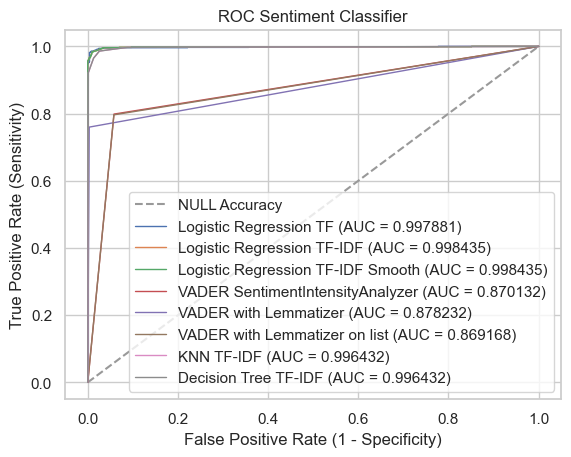

In [250]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tfidf_smooth, tpr_tfidf_smooth, lw=1, label='Logistic Regression TF-IDF Smooth (AUC = %0.6f)' % roc_auc_tfidf_smooth)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_list_lem, tpr_list_lem, lw=1, label='VADER with Lemmatizer on list (AUC = %0.6f)' % roc_auc_list_lem)
plt.plot(fpr_tfidf_knn, tpr_tfidf_knn, lw=1, label='KNN TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_knn)
plt.plot(fpr_tfidf_dt, tpr_tfidf_dt, lw=1, label='Decision Tree TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_dt)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D

X_train, X_test, y_train, y_test = train_test_split(train_data_df.comment, train_data_df.sentiment, test_size=0.33, random_state=42)

# Model
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
model_cnn.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(10, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

# Compilation
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.fit(X_train, y_train, epochs=5, validation_data=(X_train, y_train))

# classifier to label an evaluation set
# y_pred_cnn = model_cnn.predict(X=X_test_tfidf)
# y_pred_prob_tfidf_cnn = model_cnn.predict_proba(X=X_test_tfidf)[:,1]
# fpr_tfidf_cnn, tpr_tfidf_cnn, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf_cnn)
# roc_auc_tfidf_cnn = metrics.auc(fpr_tfidf_cnn, tpr_tfidf_cnn)
y_pred_cnn = (model_cnn.predict(X_test_tfidf_dense) > 0.5).astype(int)  # Próg klasyfikacji
y_pred_prob_tfidf_cnn = model_cnn.predict(X_test_tfidf_dense)  # Prawdopodobieństwa

from sklearn import metrics

fpr_cnn, tpr_cnn, thresholds = metrics.roc_curve(y_test, y_pred_prob_cnn)
roc_auc_cnn = metrics.auc(fpr_tfidf_cnn, tpr_tfidf_cnn)

In [ ]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tfidf_smooth, tpr_tfidf_smooth, lw=1, label='Logistic Regression TF-IDF Smooth (AUC = %0.6f)' % roc_auc_tfidf_smooth)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_list_lem, tpr_list_lem, lw=1, label='VADER with Lemmatizer on list (AUC = %0.6f)' % roc_auc_list_lem)
plt.plot(fpr_tfidf_knn, tpr_tfidf_knn, lw=1, label='KNN TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_knn)
plt.plot(fpr_tfidf_dt, tpr_tfidf_dt, lw=1, label='Decision Tree TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_dt)
plt.plot(fpr_cnn, tpr_cnn, lw=1, label='Convolutional Neural Network (AUC = %0.6f)' % roc_auc_cnn)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [ ]:
#Recurrent Neural Network (RNN), LSTM, i GRU
from keras.layers import SimpleRNN

model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
model_rnn.add(SimpleRNN(units=50))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_rnn.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

y_pred_tfidf_cnn = (model_cnn.predict(X_test_tfidf_dense) > 0.5).astype(int)  # Próg klasyfikacji
y_pred_prob_tfidf_cnn = model_cnn.predict(X_test_tfidf_dense)  # Prawdopodobieństwa
from sklearn import metrics
fpr_tfidf_cnn, tpr_tfidf_cnn, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf_cnn)
roc_auc_tfidf_cnn = metrics.auc(fpr_tfidf_cnn, tpr_tfidf_cnn)


In [ ]:
#LSTM
from keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))


In [ ]:
#GRU
from keras.layers import GRU

model_gru = Sequential()
model_gru.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
model_gru.add(GRU(units=50))
model_gru.add(Dense(1, activation='sigmoid'))

model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_gru.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
# 

In [ ]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tfidf_smooth, tpr_tfidf_smooth, lw=1, label='Logistic Regression TF-IDF Smooth (AUC = %0.6f)' % roc_auc_tfidf_smooth)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_list_lem, tpr_list_lem, lw=1, label='VADER with Lemmatizer on list (AUC = %0.6f)' % roc_auc_list_lem)
plt.plot(fpr_tfidf_knn, tpr_tfidf_knn, lw=1, label='KNN TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_knn)
plt.plot(fpr_tfidf_dt, tpr_tfidf_dt, lw=1, label='Decision Tree TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_dt)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_tfidf, y_train_tfidf)

# classifier to label an evaluation set
y_pred_tfid_dt = dt_model.predict(X=X_test_tfidf)
y_pred_prob_tfidf_dt = dt_model.predict_proba(X=X_test_tfidf)[:,1]
fpr_tfidf_dt, tpr_tfidf_dt, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf_knn)
roc_auc_tfidf_dt = metrics.auc(fpr_tfidf_dt, tpr_tfidf_dt)

In [ ]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tfidf_smooth, tpr_tfidf_smooth, lw=1, label='Logistic Regression TF-IDF Smooth (AUC = %0.6f)' % roc_auc_tfidf_smooth)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_list_lem, tpr_list_lem, lw=1, label='VADER with Lemmatizer on list (AUC = %0.6f)' % roc_auc_list_lem)
plt.plot(fpr_tfidf_knn, tpr_tfidf_knn, lw=1, label='KNN TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_knn)
plt.plot(fpr_tfidf_dt, tpr_tfidf_dt, lw=1, label='Decision Tree TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_dt)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)